# Stream Flow Producer

## Preparation

### Import Libraries

In [31]:
#Basic
import pandas as pd
import numpy as np
import re
import warnings
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima.arima import ndiffs, nsdiffs
from scipy.stats import shapiro
import seaborn as sns
import scipy.stats as st
import statsmodels.api as sm

#Plotting
import seaborn as sns
from matplotlib import pyplot as plt

#Herarchy
import scipy.cluster.hierarchy as sch


#Sklearn workflow
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold,GridSearchCV,TimeSeriesSplit
from sklearn.metrics import  mean_absolute_percentage_error, mean_squared_error
from sklearn.pipeline import make_pipeline


#Models
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor

In [32]:
#Formatting
pd.set_option( "display.max_columns", None,'display.max_colwidth', None)

warnings.filterwarnings("ignore")

### Defined Functions


### Read Files

In [33]:
data = pd.read_excel('Test Exercise.xlsx')

## EDA

In [34]:
data.head()

,Date,Producible,nieve,lluvia
0,2010-01-02,13334.757143,7.610519,24.681364
1,2010-01-09,17837.885714,12.568362,35.081703
2,2010-01-16,25538.671429,13.949181,7.003951
3,2010-01-23,15831.800000,10.795641,36.382501
4,2010-01-30,26064.328571,15.514463,38.670207


In [35]:
data = data.set_index('Date')
#data = data.drop(columns =['Date'])
data.head()

,Producible,nieve,lluvia
Date,,,
2010-01-02,13334.757143,7.610519,24.681364
2010-01-09,17837.885714,12.568362,35.081703
2010-01-16,25538.671429,13.949181,7.003951
2010-01-23,15831.800000,10.795641,36.382501
2010-01-30,26064.328571,15.514463,38.670207


In [36]:
data.describe()

,Producible,nieve,lluvia
count,433.000000,433.000000,433.000000
mean,9751.866480,6.520633,18.777511
std,6562.780477,9.983007,22.344496
min,500.771429,0.000000,0.000000
25%,5246.928571,0.007452,3.694767
50%,7479.642857,1.475301,10.149468
75%,12453.200000,9.852435,24.783052
max,30225.600000,54.848850,122.621131


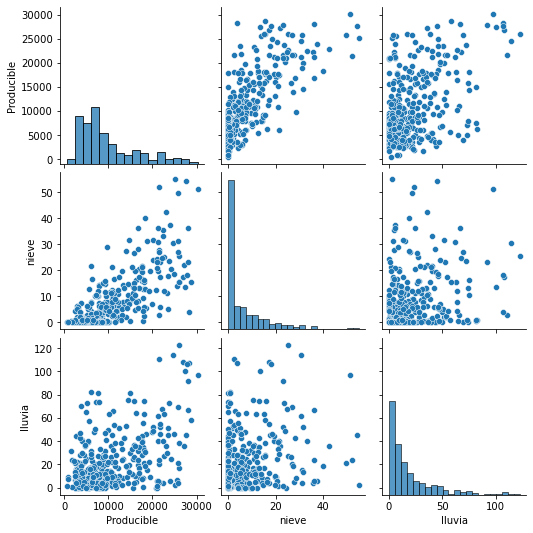

In [37]:
sns.pairplot(data)

In [38]:
# #Log
# for col in data.columns:
#     data[col] = np.log(data[col]+1)
# sns.pairplot(data)

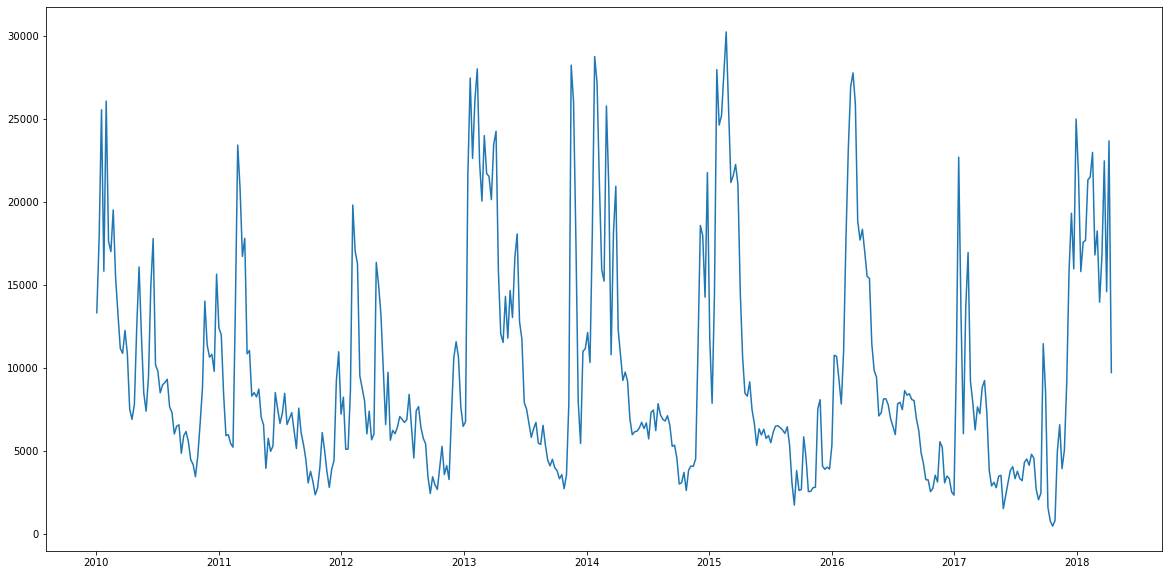

In [39]:
fig = plt.subplots(figsize =(20,10))
plt.plot(data['Producible'])

In [40]:
# years = list(range(2010,2019))
# for year in years:
#     print(data.loc[str(year),'Producible'].idxmax())

In [41]:
x = data[['nieve','lluvia']]
y = data['Producible']
nlags = 52 
s = 52

Producible: adf p-val = 4.31e-06
nieve: adf p-val = 4.72e-06
lluvia: adf p-val = 1.84e-13


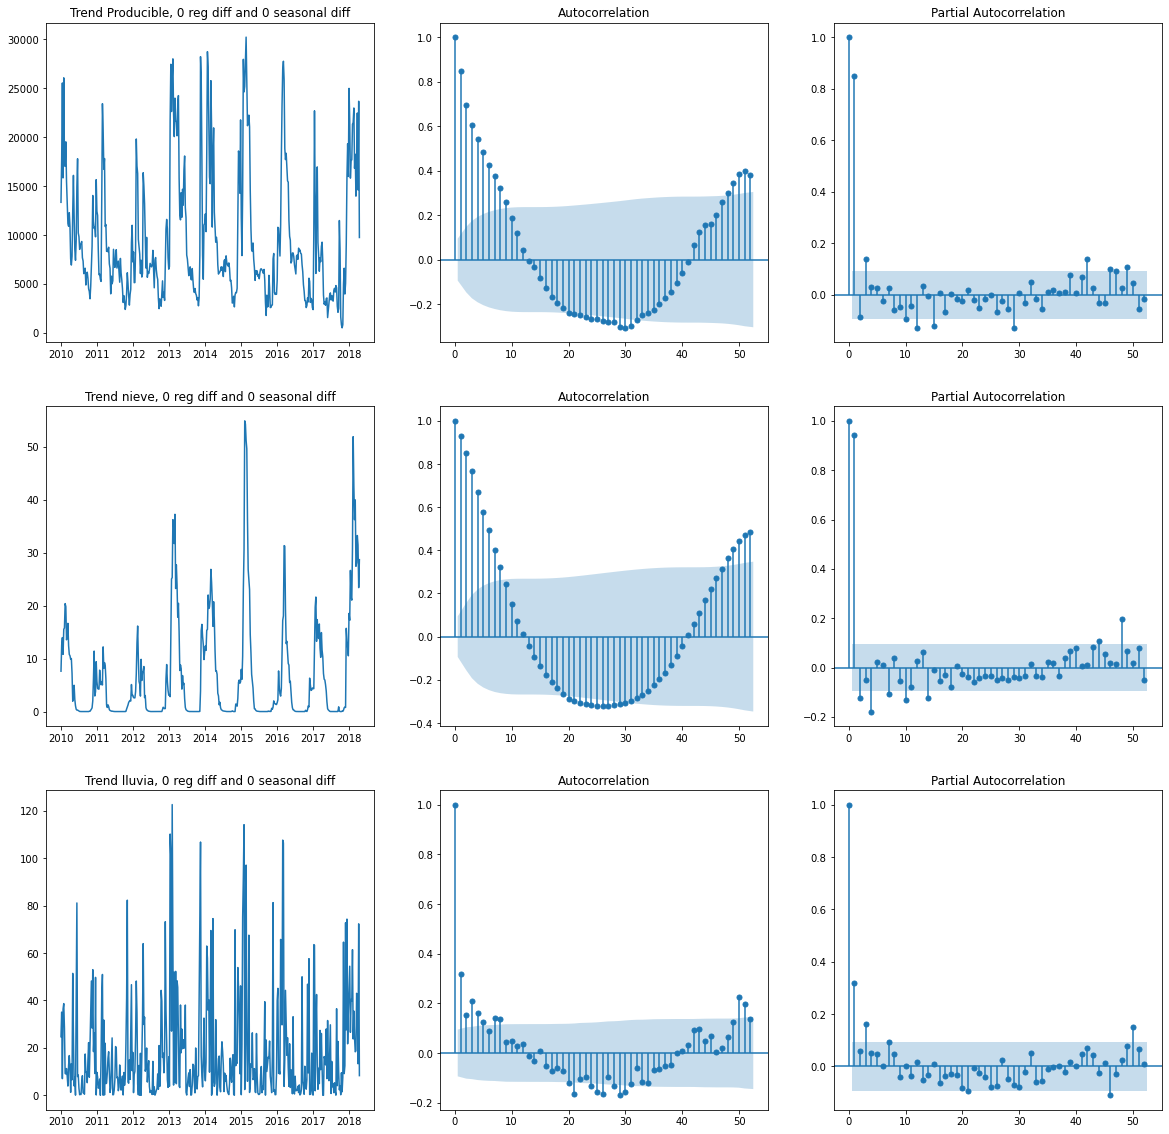

In [42]:
fig, ax = plt.subplots(3,3,figsize =(20,20))
row = 0
for col_name in data.columns:
    column = data[col_name]
    adf = sm.tsa.stattools.adfuller(column,maxlag=10)
    print(f'{col_name}: adf p-val = {adf[1]:.3}')
    #column = np.log(column+1)
    #column = column.diff().dropna()
    d = ndiffs(column, alpha = 0.05, test='adf')  # regular differences?
    D = nsdiffs(column, m = s, test='ocsb') # # seasonal differences?
    ax[row,0].plot(column)
    ax[row,0].set_title(f'Trend {col_name}, {d} reg diff and {D} seasonal diff')
    acf =plot_acf(column, lags = nlags,ax = ax[row,1])
    pacf =plot_pacf(column, method="ols",lags = nlags, ax=ax[row,2])
    row +=1


## Sarima Model

                               SARIMAX Results                                
Dep. Variable:             Producible   No. Observations:                  433
Model:               SARIMAX(3, 0, 0)   Log Likelihood               -4148.869
Date:                Tue, 05 Apr 2022   AIC                           8305.738
Time:                        13:00:26   BIC                           8322.021
Sample:                    01-02-2010   HQIC                          8312.166
                         - 04-14-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9860      0.031     31.759      0.000       0.925       1.047
ar.L2         -0.2202      0.043     -5.064      0.000      -0.305      -0.135
ar.L3          0.1957      0.040      4.949      0.0

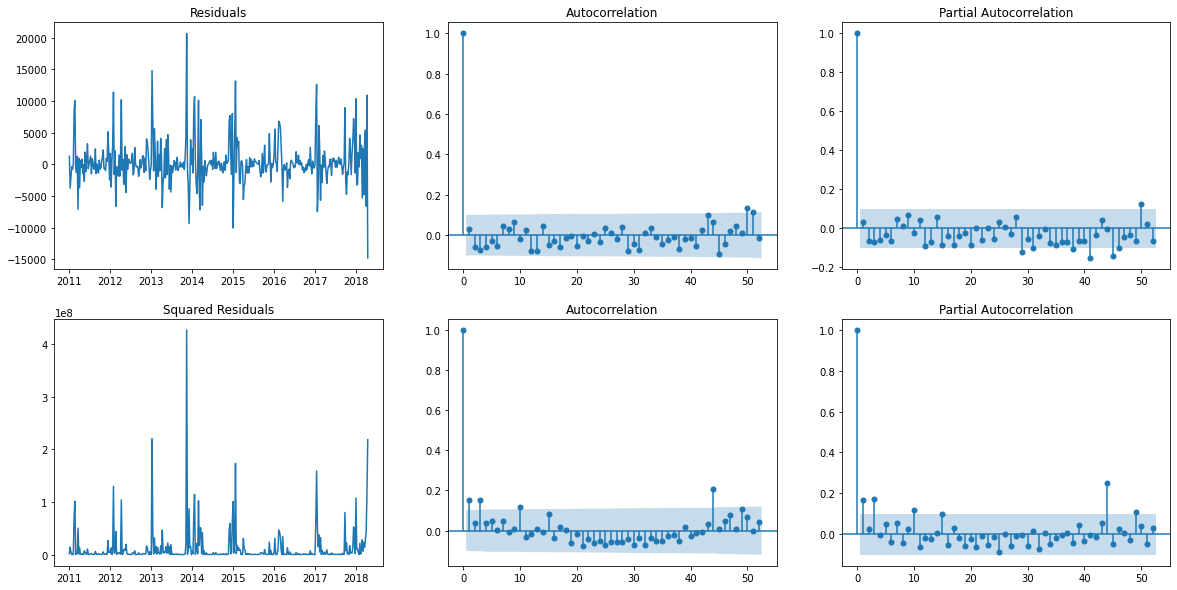

In [43]:
#Seasonality
fit = SARIMAX(endog = y, order = (3,0,0), seasonal_order = (0,0,0,s)).fit()
print(fit.summary())
residuos = fit.resid[(s+1):]
 
#Resiaudals Plots
fig, ax = plt.subplots(2,3, figsize = (20,10) )                           
ax[0,0].plot(residuos)
ax[0,0].set_title('Residuals')
acf =plot_acf(residuos, lags = nlags,ax = ax[0,1])
pacf = plot_pacf(residuos, method="ols",lags = nlags, ax=ax[0,2])

#Squared Residuals plots
ax[1,0].plot(residuos**2)
ax[1,0].set_title('Squared Residuals')
acf =plot_acf(residuos**2, lags = nlags,ax = ax[1,1])
pacf = plot_pacf(residuos**2, method="ols",lags = nlags, ax=ax[1,2])

#Test
box_test = sm.stats.acorr_ljungbox(residuos, lags=[nlags])
box_test_2 = sm.stats.acorr_ljungbox(residuos**2, lags=[nlags])
saphiro = shapiro(residuos)

print(f'P-values: Box Test: {box_test[1][0]:.4}, Squared Box Test:{box_test_2[1][0]:.4}, Shapiro:{saphiro[1]:.4}')


## Regression Model

In [44]:
data.corr()

,Producible,nieve,lluvia
Producible,1.000000,0.767463,0.515937
nieve,0.767463,1.000000,0.310327
lluvia,0.515937,0.310327,1.000000


### Regression

In [45]:
x = sm.add_constant(pd.DataFrame(x))
# print(x)

reg1 = sm.OLS(y, x).fit()
reg1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Producible   R-squared:                       0.674
Model:                            OLS   Adj. R-squared:                  0.673
Method:                 Least Squares   F-statistic:                     445.3
Date:                Tue, 05 Apr 2022   Prob (F-statistic):          1.71e-105
Time:                        13:00:26   Log-Likelihood:                -4176.7
No. Observations:                 433   AIC:                             8359.
Df Residuals:                     430   BIC:                             8372.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       5175.7183    247.244     20.934      0.000    4689.760    5661.676
nieve        441.8198     19.030     23.217      0.000     404.417     479.223
lluvia        90.2784      8.502     10.618      0.000      73.567     106.989
==============================================================================
Omnibus:                       31.176   Durbin-Watson:                   0.793
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               40.679
Skew:                           0.576   Prob(JB):                     1.47e-09
Kurtosis:                       3.963   Cond. No.                         41.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

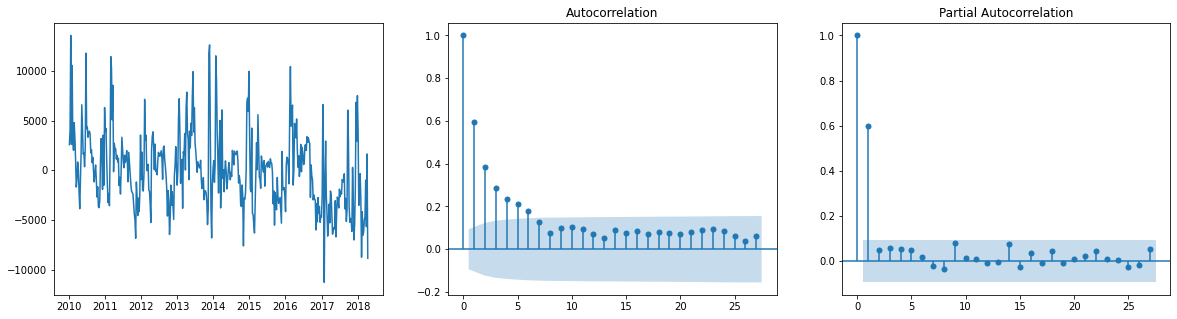

adf p-val = 5.9e-18
Regular differences:  0
Seasonal differences: 0


In [46]:
resi = reg1.resid

fig, ax = plt.subplots(1,3, figsize = (20,5))
ax[0].plot(resi)
plot_acf(resi, ax=ax[1])
plot_pacf(resi, method="ld", ax=ax[2])

plt.show()

# Tests
s = 52
d = ndiffs(resi, alpha = 0.05, test='adf')  # regular differences?
D = nsdiffs(resi, m = s, test='ocsb') # # seasonal differences?

adf = sm.tsa.stattools.adfuller(resi,maxlag=10)


print(f'adf p-val = {adf[1]:.3}')
print("Regular differences: ", d)
print('Seasonal differences:', D)

### Arima Residuals

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  433
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -4080.033
Date:                Tue, 05 Apr 2022   AIC                           8166.066
Time:                        13:00:27   BIC                           8178.279
Sample:                    01-02-2010   HQIC                          8170.887
                         - 04-14-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -21.9170    390.910     -0.056      0.955    -788.087     744.253
ar.L1          0.6035      0.036     16.933      0.000       0.534       0.673
sigma2      8.946e+06   4.28e+05     20.880      0.0

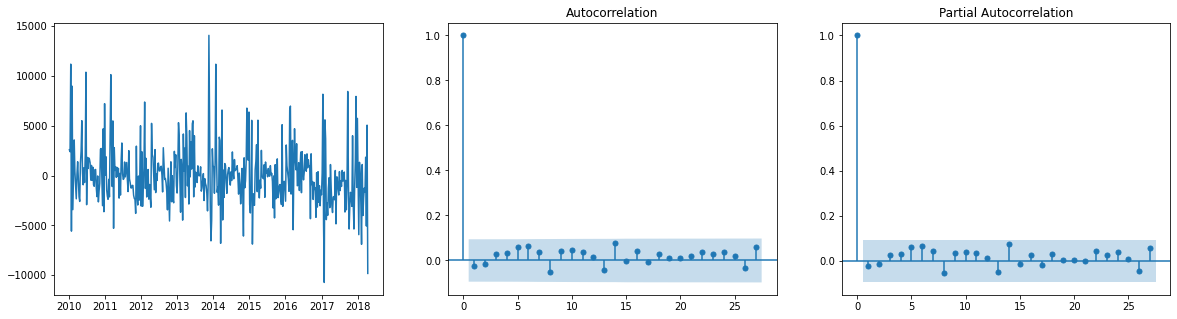

P-values: Box Test: 0.8412, Squared Box Test:0.03956, Shapiro:5.141e-11


In [47]:
fit = sm.tsa.arima.ARIMA(resi, order = (1,0,0)).fit(method = 'innovations_mle')
print(fit.summary())
resi =fit.resid
fig, ax = plt.subplots(1,3, figsize = (20,5))
ax[0].plot(resi)
plot_acf(resi, ax=ax[1])
plot_pacf(resi, method="ld", ax=ax[2])
plt.show()

#Test
box_test = sm.stats.acorr_ljungbox(resi, lags=[nlags])
box_test_2 = sm.stats.acorr_ljungbox(resi**2, lags=[nlags])
saphiro = shapiro(resi)

print(f'P-values: Box Test: {box_test[1][0]:.4}, Squared Box Test:{box_test_2[1][0]:.4}, Shapiro:{saphiro[1]:.4}')

### Combining Regression with Arima

In [48]:
del(x['const'])

                               SARIMAX Results                                
Dep. Variable:             Producible   No. Observations:                  433
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -4072.114
Date:                Tue, 05 Apr 2022   AIC                           8154.228
Time:                        13:00:27   BIC                           8174.582
Sample:                    01-02-2010   HQIC                          8162.263
                         - 04-14-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5758.6607    617.884      9.320      0.000    4547.630    6969.691
nieve        423.9957     25.909     16.365      0.000     373.215     474.776
lluvia        64.1408      5.037     12.734      0.0

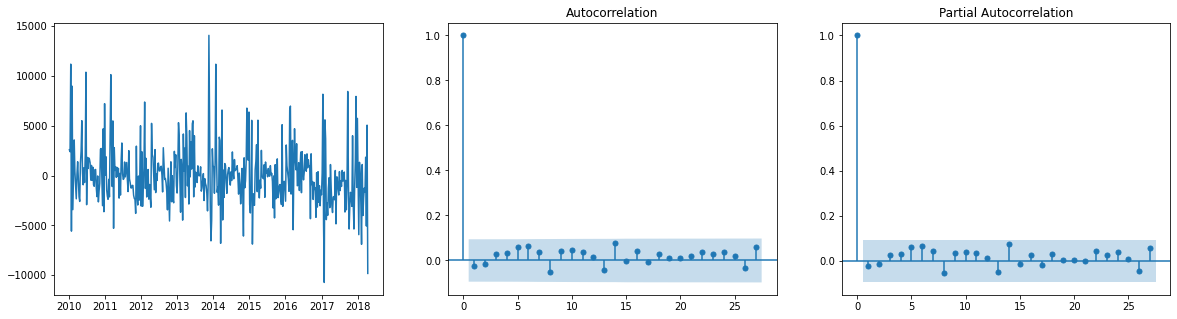

In [49]:
fit_total = sm.tsa.arima.ARIMA(endog = y, exog = x, order = (1,0,0)).fit(method = 'innovations_mle')
print(fit_total.summary())

resi =fit.resid
fig, ax = plt.subplots(1,3, figsize = (20,5))
ax[0].plot(resi)
plot_acf(resi, ax=ax[1])
plot_pacf(resi, method="ld", ax=ax[2])
plt.show()

#Test
box_test = sm.stats.acorr_ljungbox(resi, lags=[nlags])
box_test_2 = sm.stats.acorr_ljungbox(resi**2, lags=[nlags])
saphiro = shapiro(resi)

                               SARIMAX Results                                
Dep. Variable:             Producible   No. Observations:                  433
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -4072.114
Date:                Tue, 05 Apr 2022   AIC                           8154.228
Time:                        13:00:28   BIC                           8174.582
Sample:                    01-02-2010   HQIC                          8162.263
                         - 04-14-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5758.6607    617.884      9.320      0.000    4547.630    6969.691
nieve        423.9957     25.909     16.365      0.000     373.215     474.776
lluvia        64.1408      5.037     12.734      0.0

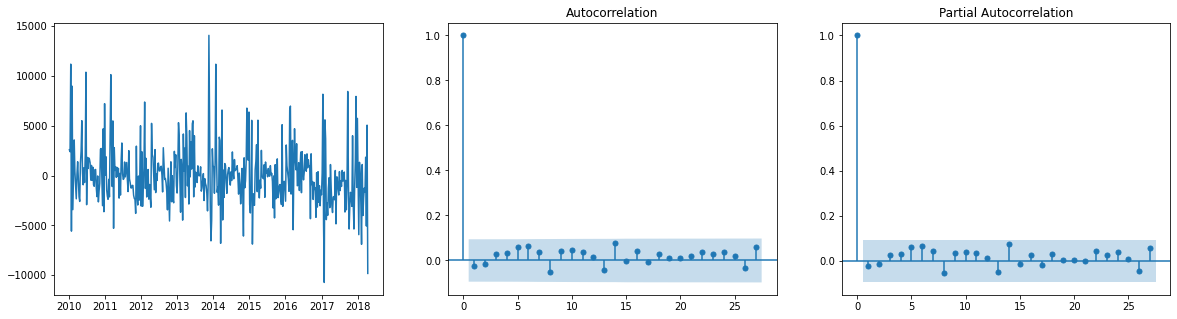

In [50]:
fit_total = sm.tsa.arima.ARIMA(endog = y, exog = x, order = (1,0,0)).fit(method = 'innovations_mle')
print(fit_total.summary())

resi =fit.resid
fig, ax = plt.subplots(1,3, figsize = (20,5))
ax[0].plot(resi)
plot_acf(resi, ax=ax[1])
plot_pacf(resi, method="ld", ax=ax[2])
plt.show()

#Test
box_test = sm.stats.acorr_ljungbox(resi, lags=[nlags])
box_test_2 = sm.stats.acorr_ljungbox(resi**2, lags=[nlags])
saphiro = shapiro(resi)

## Random Forest

### Random Forest without History

In [51]:
X_forest = x[:-100]
y_forest = y[:-100]

In [52]:
rf = RandomForestRegressor(random_state = 42)
tscv = TimeSeriesSplit(n_splits=5)
mape = cross_val_score(rf,X_forest,y_forest, cv=tscv,scoring = 'neg_mean_absolute_percentage_error')
-mape

array([0.51836973, 0.37826248, 0.33240086, 0.29566987, 0.37663654])

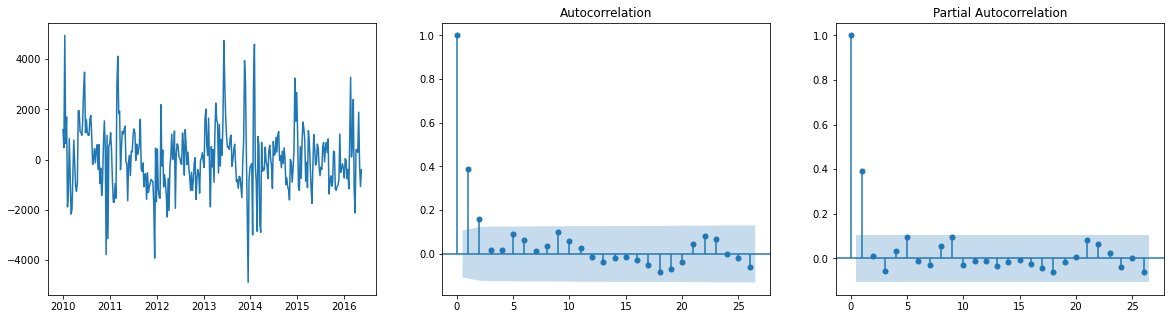

adf p-val = 2.71e-22
Regular differences:  0
Seasonal differences: 0


In [53]:
rf.fit(X_forest,y_forest)
pred = rf.predict(X_forest)
errors = y_forest - pred

fig, ax = plt.subplots(1,3, figsize = (20,5))
ax[0].plot(errors)
plot_acf(errors, ax=ax[1])
plot_pacf(errors, method="ld", ax=ax[2])

plt.show()

# Tests
s = 52
d = ndiffs(errors, alpha = 0.05, test='adf')  # regular differences?
D = nsdiffs(errors, m = s, test='ocsb') # # seasonal differences?

adf = sm.tsa.stattools.adfuller(errors,maxlag=10)


print(f'adf p-val = {adf[1]:.3}')
print("Regular differences: ", d)
print('Seasonal differences:', D)

                               SARIMAX Results                                
Dep. Variable:             Producible   No. Observations:                  333
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -2833.716
Date:                Tue, 05 Apr 2022   AIC                           5673.433
Time:                        13:00:29   BIC                           5684.857
Sample:                    01-02-2010   HQIC                          5677.989
                         - 05-14-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         52.0837    109.225      0.477      0.633    -161.994     266.161
ar.L1          0.3901      0.039     10.093      0.000       0.314       0.466
sigma2      1.441e+06   7.93e+04     18.168      0.0

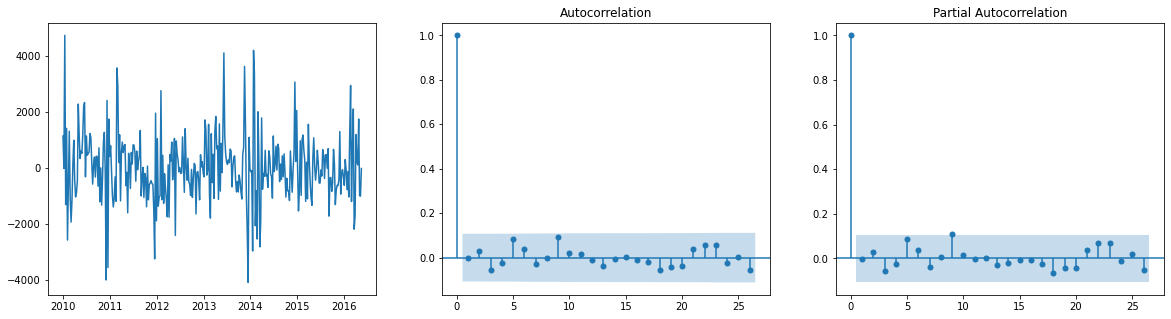

P-values: Box Test: 0.9884, Squared Box Test:0.000192, Shapiro:7.893e-07


In [54]:
fit = sm.tsa.arima.ARIMA(errors, order = (1,0,0)).fit(method = 'innovations_mle')
print(fit.summary())
resi =fit.resid
fig, ax = plt.subplots(1,3, figsize = (20,5))
ax[0].plot(resi)
plot_acf(resi, ax=ax[1])
plot_pacf(resi, method="ld", ax=ax[2])
plt.show()

#Test
box_test = sm.stats.acorr_ljungbox(resi, lags=[nlags])
box_test_2 = sm.stats.acorr_ljungbox(resi**2, lags=[nlags])
saphiro = shapiro(resi)

print(f'P-values: Box Test: {box_test[1][0]:.4}, Squared Box Test:{box_test_2[1][0]:.4}, Shapiro:{saphiro[1]:.4}')

### Random Forest with History

In [55]:
rf_data = data.copy()
rf_data['lag_1'] = rf_data['Producible'].shift(1)
rf_data['lag_2'] = rf_data['Producible'].shift(2)
rf_data['lag_3'] = rf_data['Producible'].shift(3)
rf_data = rf_data.dropna()

In [56]:
X_forest = rf_data.drop(columns=['Producible'])[:-100]
y_forest = rf_data['Producible'][:-100]
x_test_forest = rf_data.drop(columns=['Producible'])[-100:] #more columns
y_test_forest = rf_data['Producible'][-100:]

In [57]:
rf2 = RandomForestRegressor(random_state = 42)
tscv = TimeSeriesSplit(n_splits=5)
mape = cross_val_score(rf,X_forest,y_forest, cv=tscv,scoring = 'neg_mean_absolute_percentage_error')
-mape

array([0.25363184, 0.22339691, 0.20634167, 0.16585295, 0.20790648])

## Testing

In [58]:
x_train = x[:-100]
x_test = x[-100:]
y_train = y[:-100]
y_test = y[-100:]

In [59]:
def arima_pred(x,y,steps = 100,way ='expand'):
    
    #Arima models
    arima = []
    arimax = []
    rf_arima = []
    
    for num in range(100,0,-steps):
        if steps == num:
            x_forecast = x[-num:]
        else:
            x_forecast = x[-num:(-num+steps)]
        if way =='rolling':
            y_t = y[100-num:-num]
            x_t = x[100-num:-num]
        else:
            y_t = y[:-num]
            x_t = x[:-num]

        fit_sarima = SARIMAX(endog = y_t, order = (3,0,0), seasonal_order = (0,0,0,s)).fit()
        fit_total = sm.tsa.arima.ARIMA(endog = y_t, exog = x_t, order = (1,0,0)).fit(method = 'innovations_mle')
#         rf_fit = rf.fit(x_t,y_t)
#         pred = rf.predict(x_t)
#         errors = y_t - pred
#         fit_rf = sm.tsa.arima.ARIMA(errors, order = (1,0,0)).fit(method = 'innovations_mle')
        
        
        y_pred1 = fit_sarima.forecast(steps = steps)
        y_pred2 = fit_total.forecast(exog = x_forecast ,steps = steps)
#         y_pred3 = rf_fit.predict(x_forecast)+ fit_rf.forecast(steps = steps)
        arima.extend(y_pred1)
        arimax.extend(y_pred2)
#         rf_arima.extend(y_pred3)
    
    # Random Forest models
    
    rf_nolags_fit = rf.fit(x_train,y_train)
    rf_lags_fit = rf2.fit(X_forest,y_forest)
    
    rf_nolags = rf_nolags_fit.predict(x_test)
    rf_lags   = rf_lags_fit.predict(x_test_forest)
    
    # DataFrame Predictions
    
    predictions = pd.DataFrame({'sarima': arima, 'sarimax':arimax,'rf_arima':rf_arima,
                                'Random Forest':rf_nolags,'Random Forest With Lags':rf_lags,
                               'y_test':y_test},
                               index = x_test.index)
    #log
#     for col in predictions.columns:
#         predictions[col] = np.exp(predictions[col])-1
        
    return predictions
    

In [60]:
def metrics(predictions):
    #Metrics 
    mape = []
    rmse = []
    for col in predictions.columns[:-1]:
        column = predictions[col]
        mape.append(mean_absolute_percentage_error(predictions['y_test'],column))
        rmse.append(np.sqrt(mean_squared_error(predictions['y_test'],column)))
        
    metrics = pd.DataFrame({'mape':mape,'rmse':rmse},index=predictions.columns[:-1] )
    
    #Chart 
    
    fig = plt.subplots(figsize =(20,10))
    plt.plot(predictions['y_test'], label = 'Real')
    for col in predictions.columns[:-1]:
        plt.plot(predictions[col], label =col, linestyle = ':')
    plt.legend()
    return metrics

,mape,rmse
sarima,0.568171,9004.782798
sarimax,1.017529,4760.724439
rf_arima,0.941128,4590.600259
Random Forest,0.931832,4559.086104
Random Forest With Lags,0.479682,2994.845047


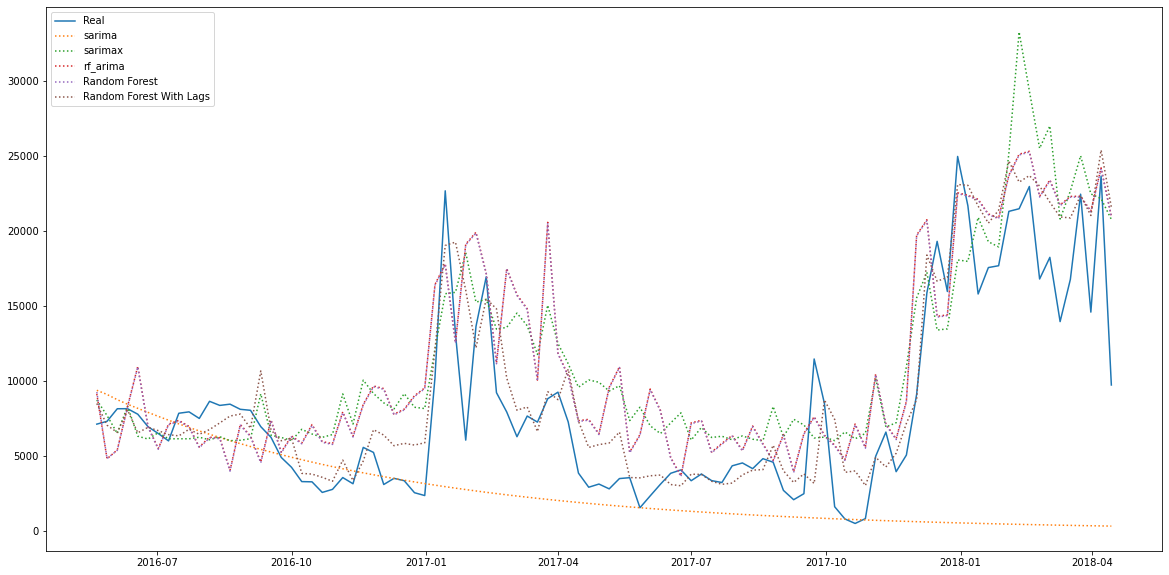

In [61]:
#100 steps
predictions = arima_pred(x,y,steps = 100,way ='expand')
metrics(predictions)

,mape,rmse
sarima,0.597458,4507.145658
sarimax,0.812251,3745.694095
rf_arima,0.882779,4255.479816
Random Forest,0.931832,4559.086104
Random Forest With Lags,0.479682,2994.845047


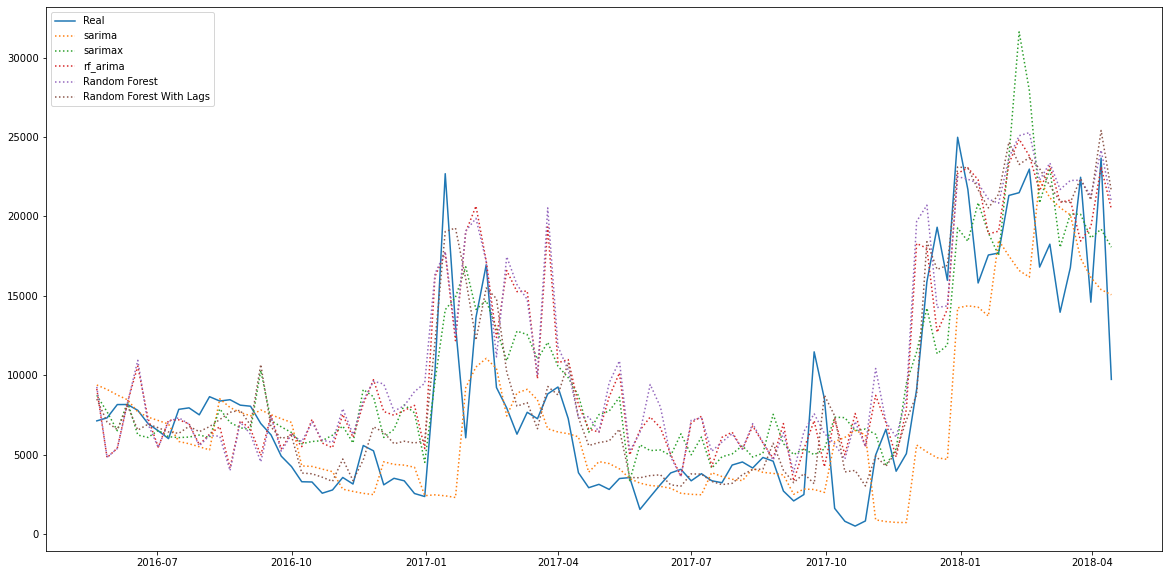

In [62]:
#4 steps (monthly)
predictions = arima_pred(x,y,steps = 4,way ='expand')
metrics(predictions)

,mape,rmse
sarima,0.319911,3676.421524
sarimax,0.494438,3382.814730
rf_arima,0.785872,3999.805030
Random Forest,0.931832,4559.086104
Random Forest With Lags,0.479682,2994.845047


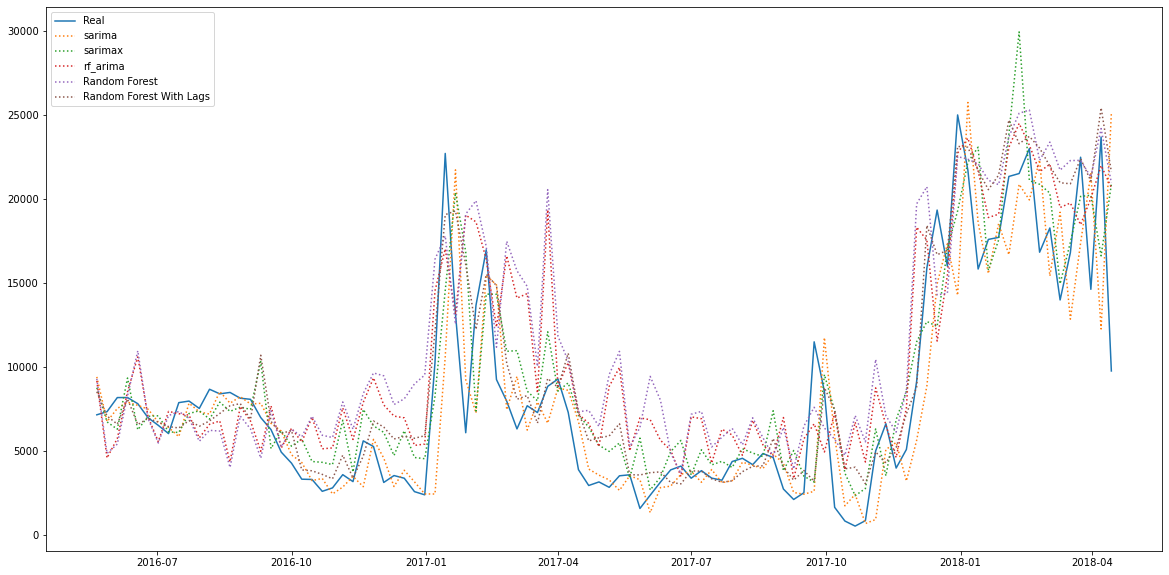

In [63]:
# 1 step (Weekly)
predictions = arima_pred(x,y,steps = 1,way ='expand')
metrics(predictions)